In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [ ]:
df = pd.read_excel('rest_premiums.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [ ]:
#Now that there is genetical_risk column for young people <= 25 years, let us add one dummy column here as well
df['Genetical_Risk'] = 0

In [ ]:
df.shape

(29904, 14)

In [ ]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

## **Handle NA Values**

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,9
employment_status,1
income_level,9
income_lakhs,0


In [ ]:
null_columns = df.columns[df.isnull().sum() > 0]
null_columns_types = df[null_columns].dtypes

print(null_columns_types)

smoking_status       object
employment_status    object
income_level         object
dtype: object


In [ ]:
df['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)
df['employment_status'].fillna(df['employment_status'].mode()[0], inplace=True)
df['income_level'].fillna(df['income_level'].mode()[0], inplace=True)

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,0
employment_status,0
income_level,0
income_lakhs,0


In [ ]:
df.shape

(29904, 14)

## **Check for duplicates**

In [ ]:
df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

In [ ]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29904.000000,29904.000000,29904.000000,29904.000000,29904.0
mean,43.396536,2.380116,23.362059,20893.036684,0.0
std,13.411893,1.431140,24.737076,6935.844219,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15698.000000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


* In the 'age' column, the max age is 356 years which is definelty an outlier.

* In the 'numer_of_dependants' column the minum number of dependants is -3 which is not practically possible (there can be no dependants at all but there cannot be negative dependants), which is definetly an outlier

* In the 'income_lakhs' column, the min is 1 lakh, but max is 9.3 cr. This gives a skewed distribution.

So, these need to be handled.

In [ ]:
df[df.number_of_dependants<0].shape

(50, 14)

In [ ]:
#let us check the unique values for the above cell (where the number_of_dependants are <0)
df[df.number_of_dependants<0].number_of_dependants.unique()

array([-1, -3])

In [ ]:
#Converting the above rows that have negative value for number of dependants to positive value
df['number_of_dependants'] = df['number_of_dependants'].apply(lambda x: abs(x))

In [ ]:
df['number_of_dependants'].describe()

,number_of_dependants
count,29904.000000
mean,2.386136
std,1.421082
min,0.000000
25%,1.000000
50%,3.000000
75%,3.000000
max,5.000000


## **Exploratory Data Analysis**

### **Outleir treatment**

#### **1. 'age' column**


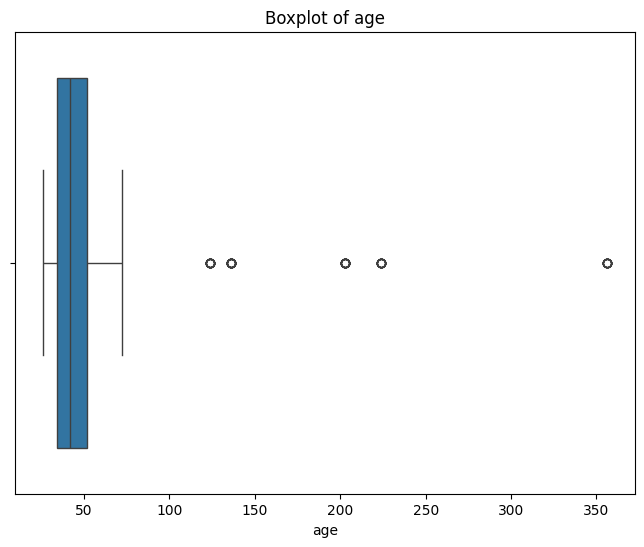

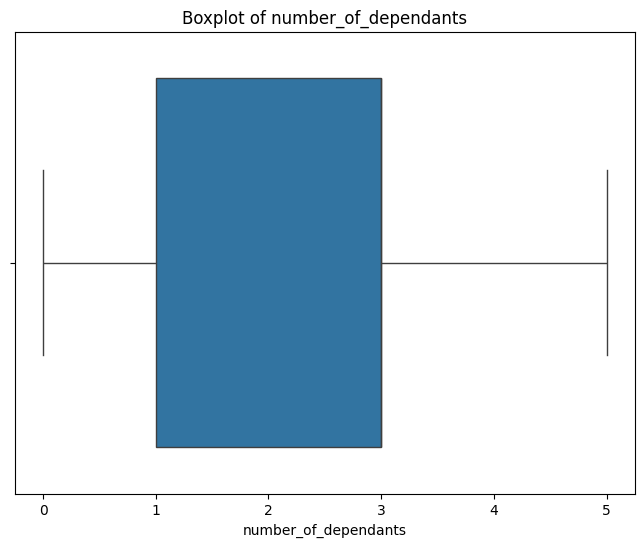

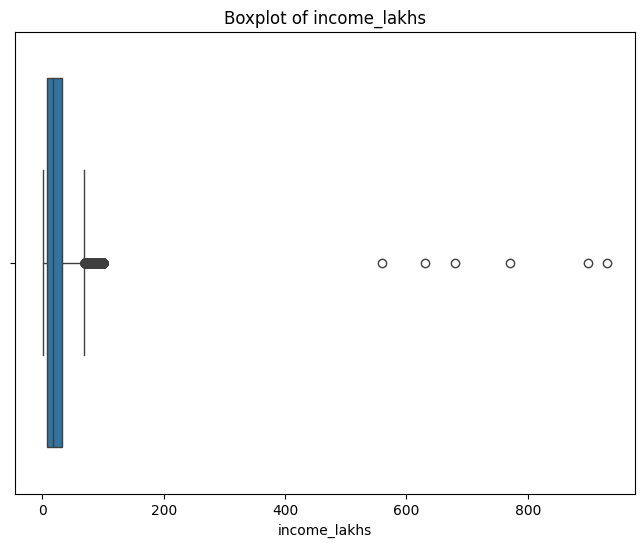

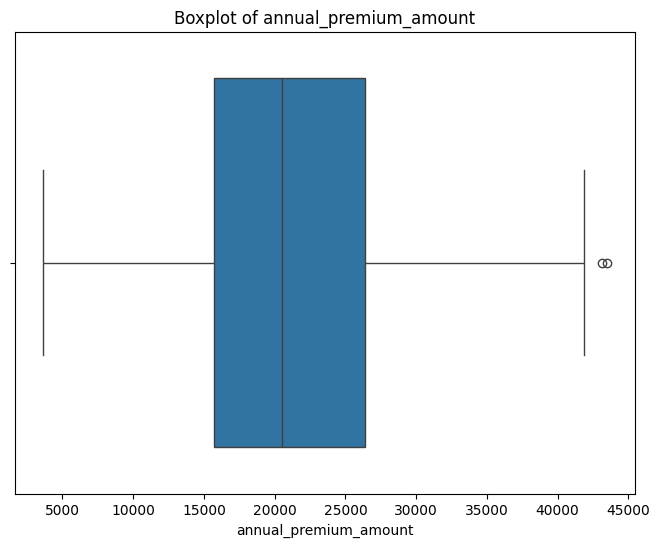

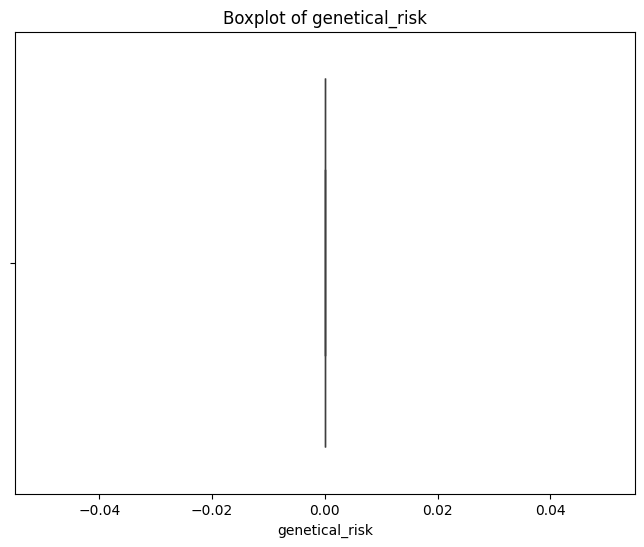

In [ ]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Create box plots for each numeric column
for col in numeric_cols:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col}')
  plt.show()


In [ ]:
# Option 1: Include all the records that have age <=100 only
df = df[df['age'] <= 100]

# Calculate the IQR (Interquartile Range)
# Q1 = df['age'].quantile(0.25)
# Q3 = df['age'].quantile(0.75)
# IQR = Q3 - Q1

# # Define the lower and upper bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Identify outliers
# outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

# # Handle outliers (e.g., capping or removal)
# # Option 2: Capping
# df['age'] = np.clip(df['age'], lower_bound, upper_bound)

# Option 3: Removal (if appropriate)
# df = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

In [ ]:
df['age'].describe()

,age
count,29846.000000
mean,43.095993
std,11.042658
min,26.000000
25%,34.000000
50%,42.000000
75%,52.000000
max,72.000000


#### **2. 'income_lakhs'**

<Axes: xlabel='income_lakhs', ylabel='Count'>

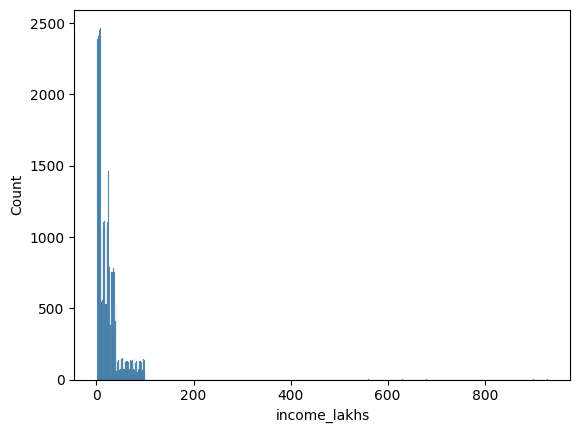

In [ ]:
sns.histplot(df['income_lakhs'])

In [ ]:
#Define a function and call IQR method to get IQR bounds
def iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [ ]:
iqr_bounds(df['income_lakhs'])

(-30.5, 69.5)

The lower bound is -29.0. The min is 1 lakh. So, this need not be handled. But the upper bound is 67.0 lakhs which is not very high salary. So, we will do some trial and error and talk to business stake holders what amount of income they want us to consider as upper bound. Here I am considering 1cr as upper bound.

#### **Find the quantile value that has 100.0 in income_lakhs value (1cr as income) as upper bound**

In [ ]:
# # find the quantile value that has 100.0 in income_lakhs value (1cr as income) as upper bound

# # First, sort the column
# sorted_income = df['income_lakhs'].sort_values()

# # Find the quantile where the value is 100.0
# quantile_value = df['income_lakhs'].quantile(q=sorted_income.searchsorted(100.0) / len(sorted_income))

# print(f"The quantile value for an upper bound of 100.0 in Income_Level is: {quantile_value}")

* searchsorted(100.0) finds the index position where 100.0 would be inserted to maintain order.

* Dividing by len(sorted_income) normalizes this index to the range [0, 1], which is what quantile expects.

* quantile(q=...) then gives the quantile corresponding to this normalized index.

This will give you the quantile in which 100.0 is the upper bound for income_lakhs column.

##### **OR THE BELOW CODE CAN ALSO BE USED**

In [ ]:
# Calculate the exact quantile for the value 100.0 in income_lakhs
quantile_value = df['income_lakhs'].rank(pct=True)[df['income_lakhs'] == 100.0].min()

print(f"The quantile value corresponding to an upper bound of 100.0 in income_lakhs is: {quantile_value}")

The quantile value corresponding to an upper bound of 100.0 in income_lakhs is: 0.9986765395697916


* rank(pct=True): This ranks the data in the income_lakhs column and normalizes it to a percentage (0 to 1 scale).

* df['income_lakhs'] == 100.0: This condition finds the positions in the DataFrame where the value is exactly 100.0.

* .min(): If there are multiple occurrences of 100.0, .min() returns the smallest rank (i.e., the lowest quantile) where 100.0 appears.

This method will give us the correct quantile where 100.0 is the upper bound in our income_lakhs data.

In [ ]:
quantile_threshold = df['income_lakhs'].quantile(quantile_value)
quantile_threshold

100.0

In [ ]:
df[df.income_lakhs > quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
1598,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692,0
4657,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010,0
5399,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848,0
6149,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945,0
21176,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115,0
24489,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926,0


In [ ]:
df[df.income_lakhs > quantile_threshold].shape

(6, 14)

There are just 10 records that are above threshold. These can either be dropped or imputation (like mean and median) can be performed on the data.

In [ ]:
## The code to perform imputation is here
# median_income = df['income_lakhs'].median()
# df.loc[df['income_lakhs'] > quantile_threshold, 'income_lakhs'] = median_income

In [ ]:
## Just dropping those 10 records
df = df[df['income_lakhs'] <= quantile_threshold]
df['income_lakhs'].describe()

,income_lakhs
count,29840.000000
mean,23.224296
std,22.453240
min,1.000000
25%,7.000000
50%,17.000000
75%,32.000000
max,100.000000


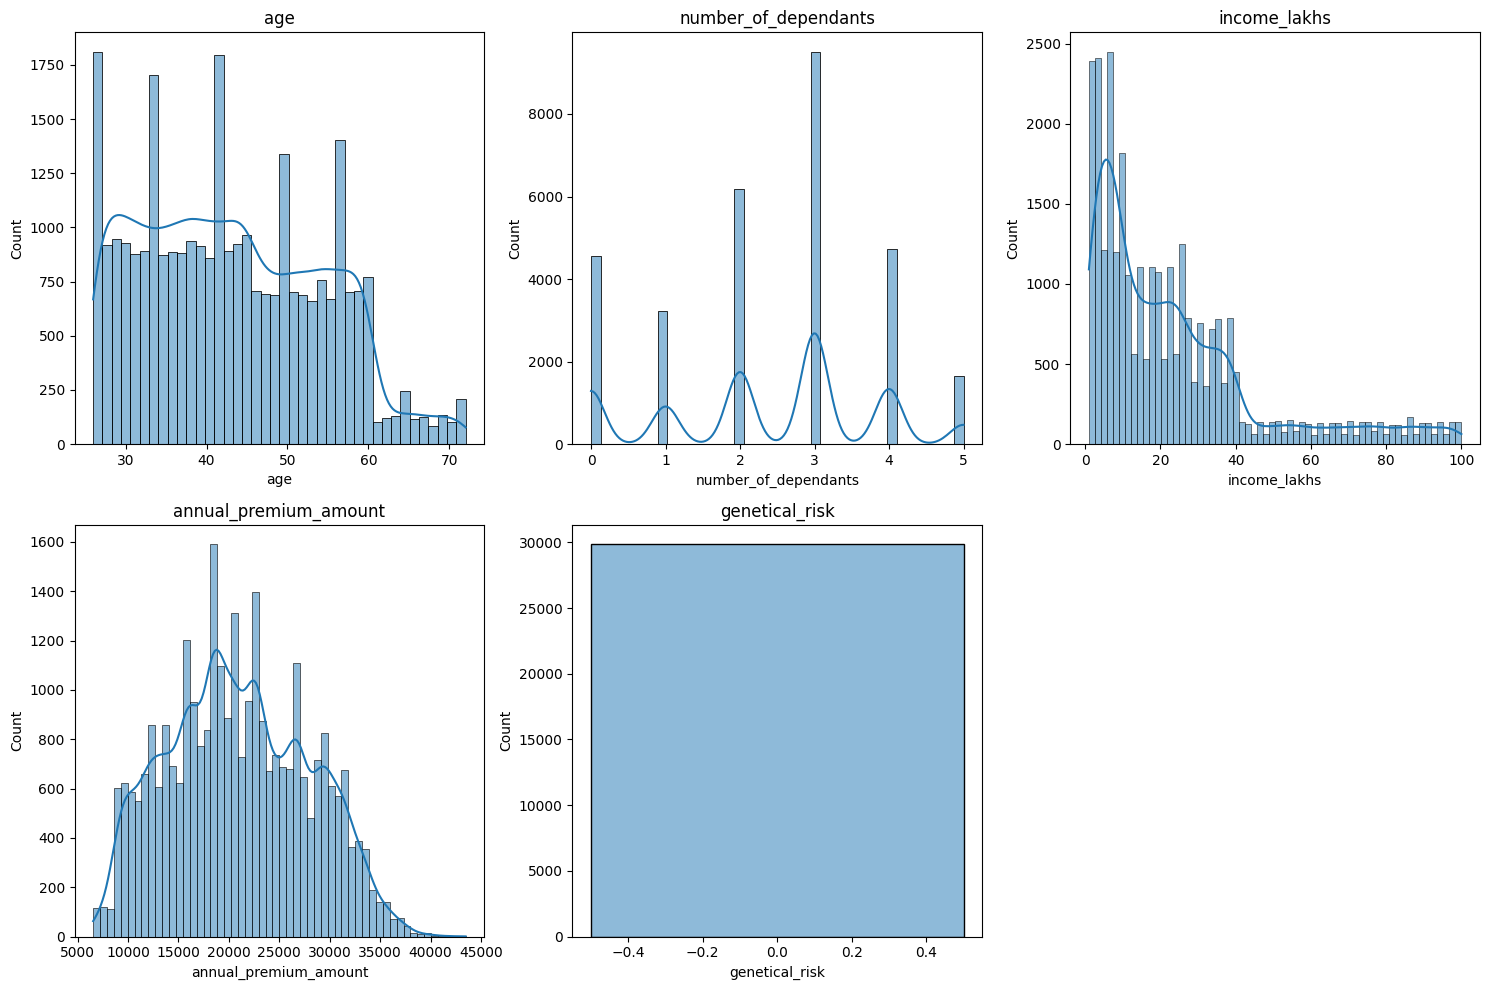

In [ ]:
#hist plot on numeric data
numeric_cols = df.select_dtypes(include=np.number).columns
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 10))

for i, col in enumerate(numeric_cols):
  ax = axs[i//3, i%3]
  sns.histplot(df[col], ax=ax, kde=True)
  ax.set_title(col)

# If the last subplot axis is unused, it can turned off
if len(numeric_cols) % 3 != 0:
  for j in range(len(numeric_cols), 6):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

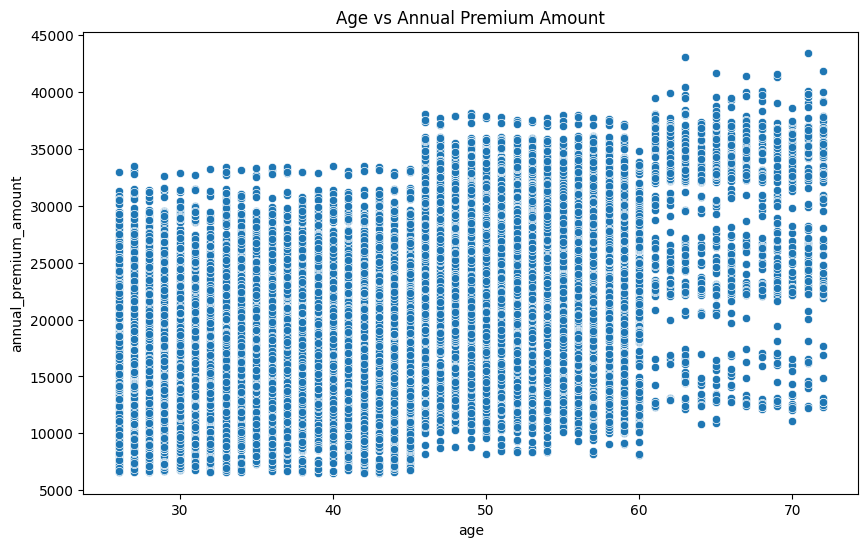

In [ ]:
#Scatterplot to see the relation between age and annual_premium_amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='annual_premium_amount', data=df)
plt.title('Age vs Annual Premium Amount')
plt.show()

As age increases, the annual_premium_amount increases.

In [ ]:
#Correlation between age and annual_premium_amount
df[['age', 'annual_premium_amount']].corr()

,age,annual_premium_amount
age,1.000000,0.484756
annual_premium_amount,0.484756,1.000000


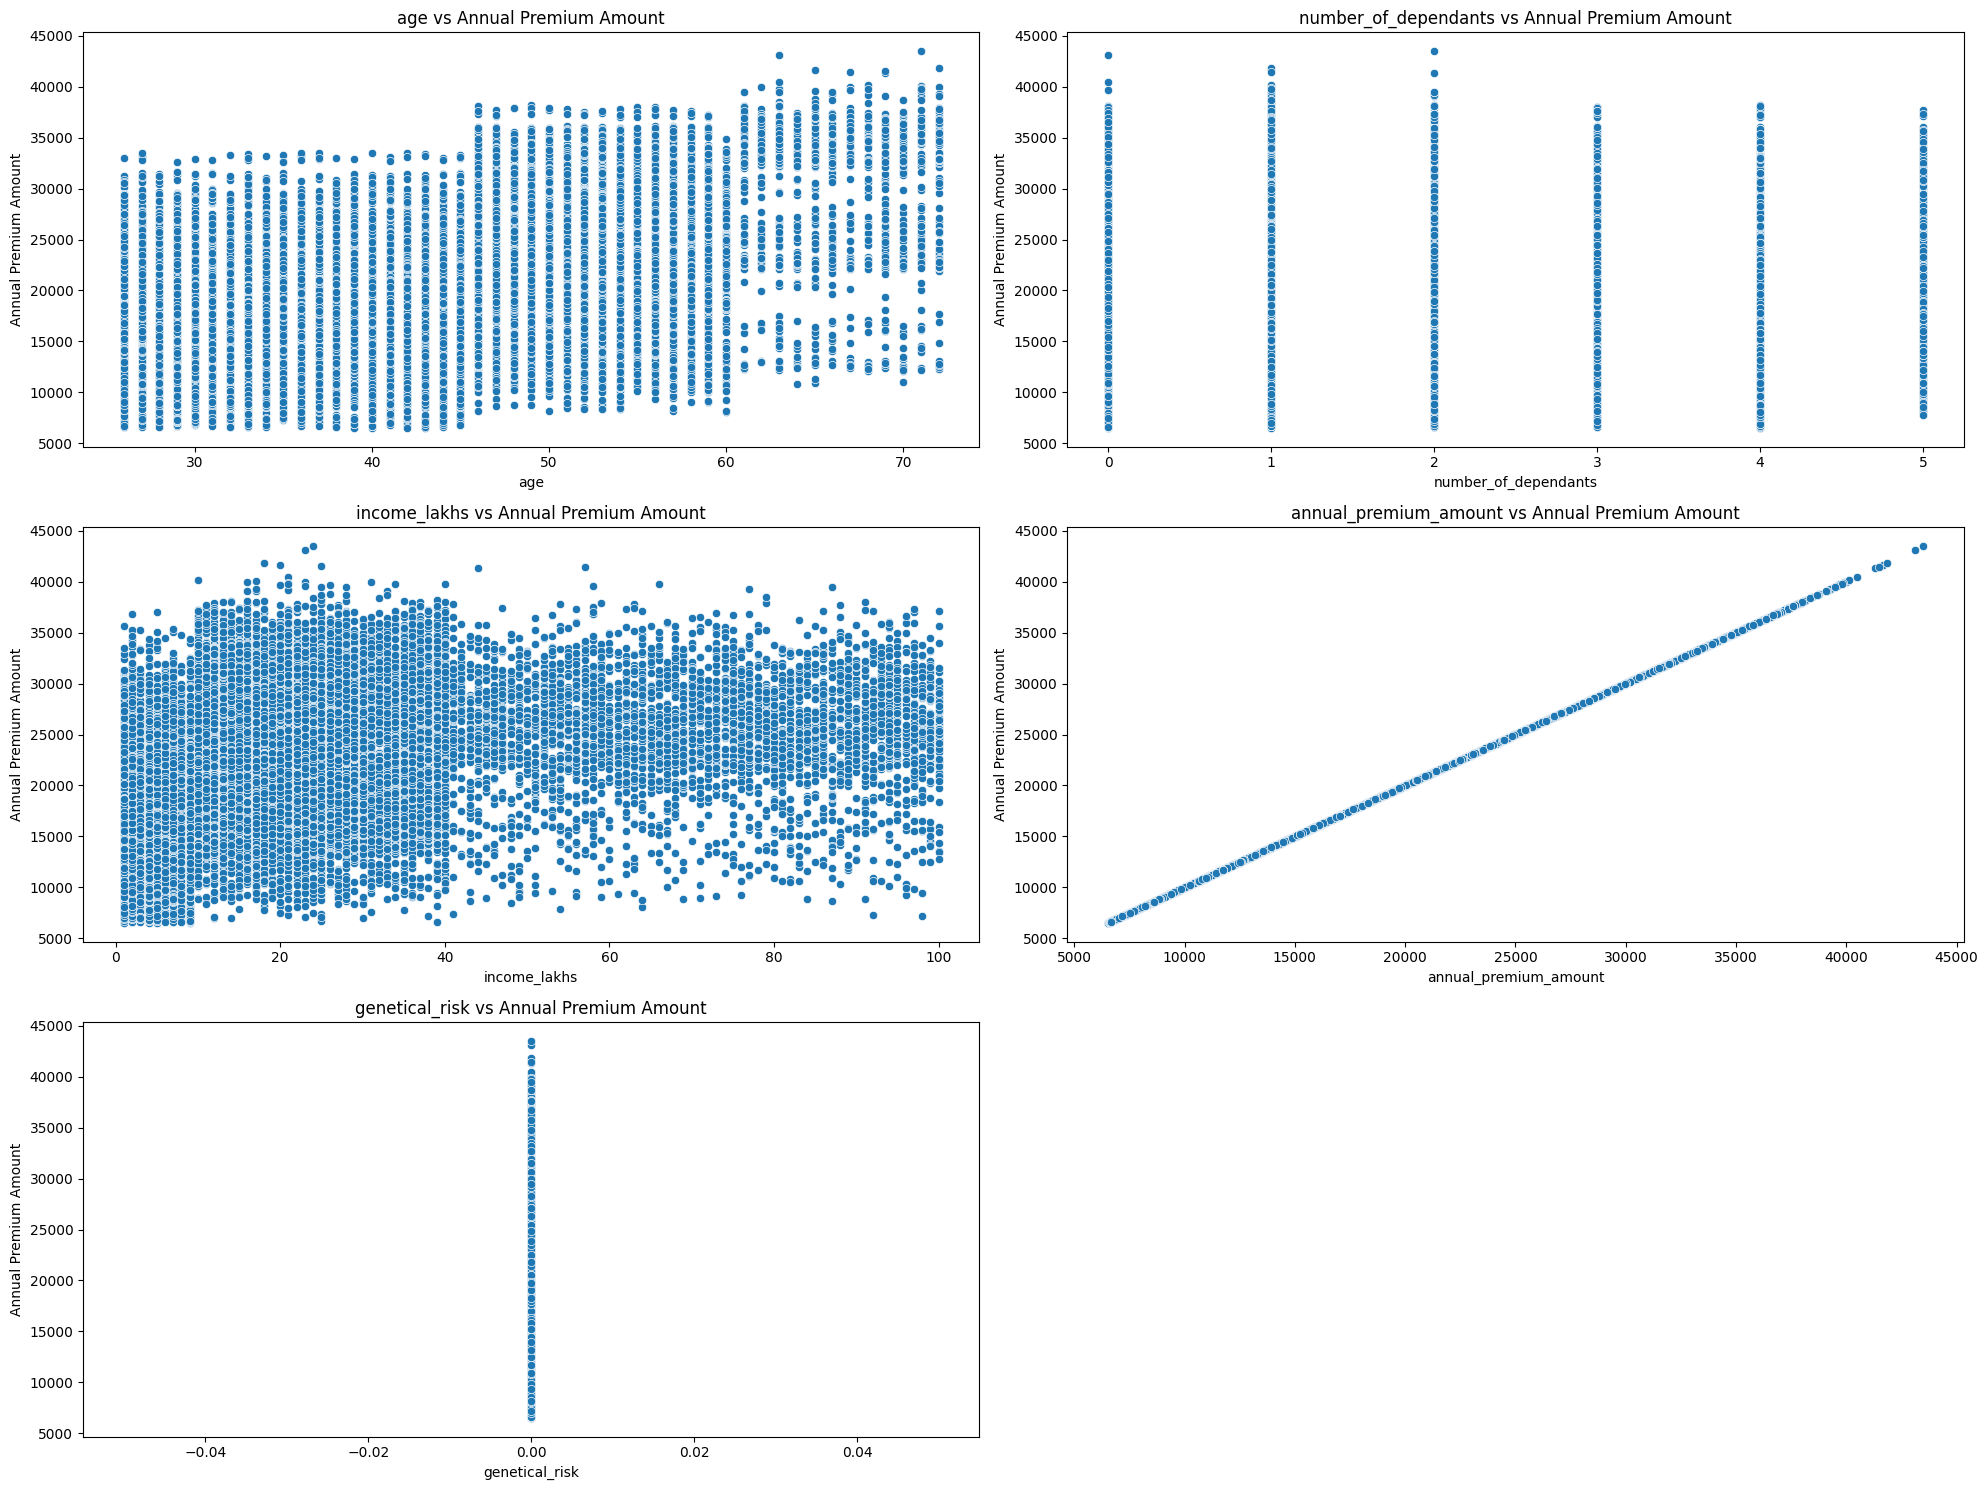

In [ ]:
#For loop for all numeric columns vs annual_premium_amount scatter plot with subplots

# Number of columns per row
n_cols = 2
# Calculate the number of rows needed
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create subplots with the calculated number of rows and columns
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Flatten the 1D array of axes if there are more than one row
if n_rows > 1:
  axs = axs.flatten()

# Loop through each column in the DataFrame

for ax, col in zip(axs, numeric_cols):
  sns.scatterplot(x=col, y='annual_premium_amount', data=df, ax=ax)
  ax.set_title(f'{col} vs Annual Premium Amount')
  ax.set_xlabel(col)
  ax.set_ylabel('Annual Premium Amount')

# Remove any empty subplots if there are fewer columns than rows
for ax in axs[len(numeric_cols):]:
  fig.delaxes(ax)

plt.tight_layout()
plt.show()

'age', 'income_lakhs' and 'annual_premium_amount' are right skewed.

In [ ]:
#Get categorical columns and print unique values in each of those columns
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
  print(f"{col}: {df[col].unique()}")

gender: ['Male' 'Female']
region: ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status: ['Unmarried' 'Married']
bmi_category: ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status: ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status: ['Salaried' 'Self-Employed' 'Freelancer']
income_level: ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history: ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan: ['Bronze' 'Silver' 'Gold']


smoking_status: ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking'] has 'Smoking=0' 'Does Not Smoke'
 'Not Smoking' values which means 'No Smoking'. This has to be handled.

In [ ]:
df['smoking_status'].replace({'Smoking=0': 'No Smoking',
                              'Does Not Smoke': 'No Smoking',
                              'Not Smoking':'No Smoking'},
                             inplace=True)

df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [ ]:
df['gender'].value_counts(normalize = True)

,proportion
gender,
Male,0.549095
Female,0.450905


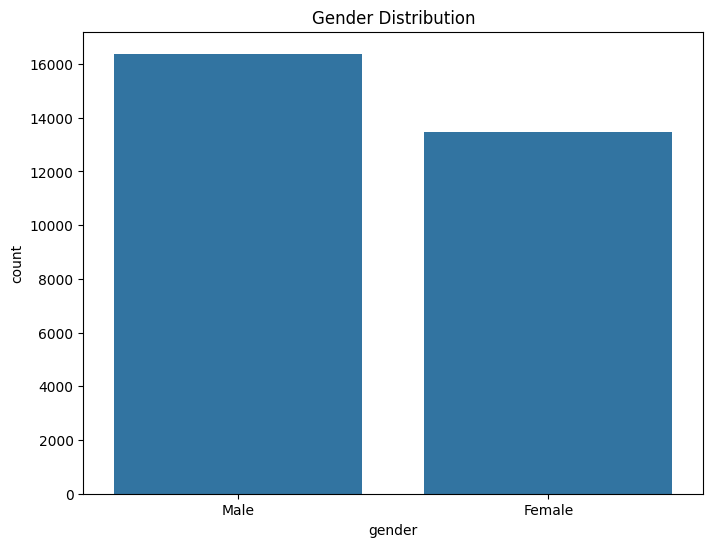

In [ ]:
#Plot bar chart for gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

<ipython-input-64-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-64-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-64-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-64-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-64-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-64-f97c5b41dfaf>:9: UserWarning: FixedFormatter should 

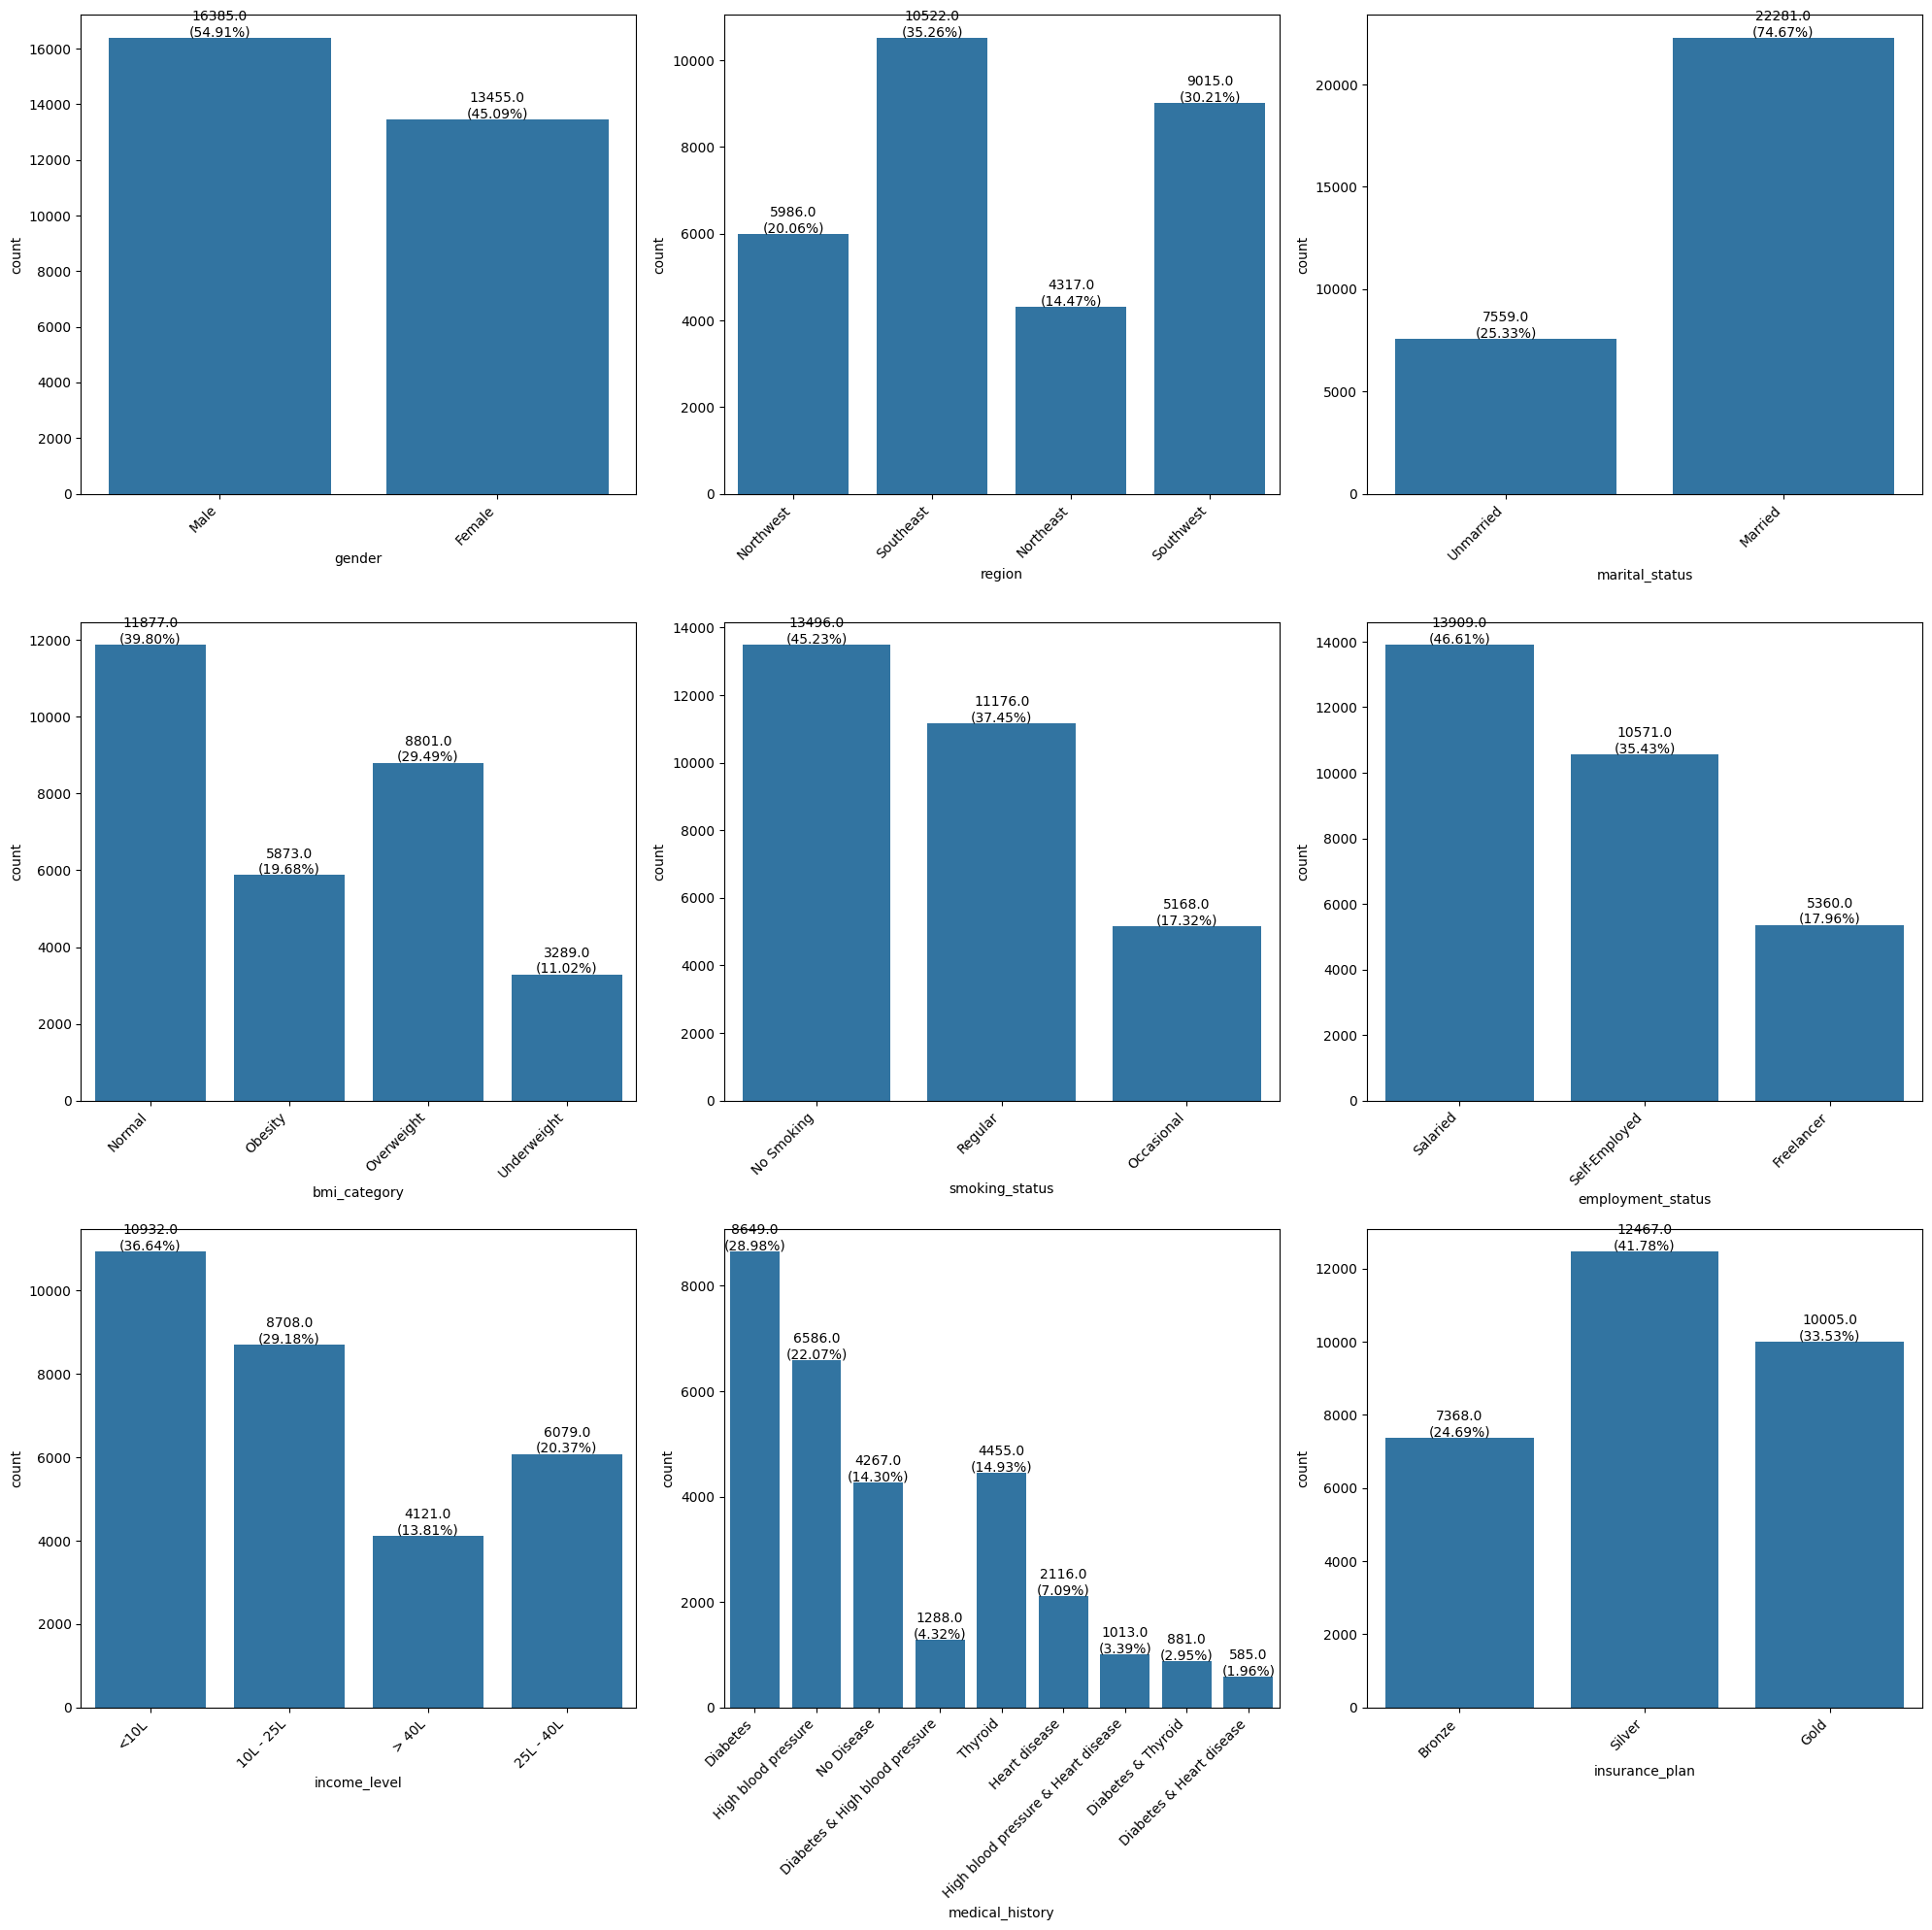

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

# Rotate labels and plot bar chart with count and percentages in it
for i, col in enumerate(categorical_cols):
  counts = df[col].value_counts()
  percentages = counts / counts.sum()
  sns.countplot(x=col, data=df, ax=axs[i])
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
  for p in axs[i].patches:
    axs[i].annotate(f'{p.get_height()}\n({100*p.get_height()/len(df):.2f}%)',
     (p.get_x()+p.get_width()/2., p.get_height()), ha='center',
                    va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.show()

# for i, col in enumerate(categorical_cols):
#   sns.countplot(x=col, data=df, ax=axs[i])
#   axs[i].set_title(f'Distribution of {col}')
#   axs[i].set_xlabel(col)
#   axs[i].set_ylabel('Count')

# plt.tight_layout()
# plt.show()


In [ ]:
#Based on income_level, what kind of insurance plan people are getting
df.groupby('income_level')['insurance_plan'].value_counts(normalize = True)

income_level  insurance_plan
10L - 25L     Silver            0.500115
              Gold              0.408130
              Bronze            0.091755
25L - 40L     Silver            0.516861
              Gold              0.433624
              Bronze            0.049515
<10L          Bronze            0.553787
              Silver            0.398006
              Gold              0.048207
> 40L         Gold              0.797865
              Silver            0.150206
              Bronze            0.051929
Name: proportion, dtype: float64

Printing the same in more understandable format

In [ ]:
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4355
25L - 40L,301,2636,3142
<10L,6054,527,4351
> 40L,214,3288,619


Less than 10L are mostly preferring Bronze plan.

Greater than 40L are mostly preferring Gold plan.

Text(0.5, 1.0, 'Distribution of Insurance Plans by Income Level')

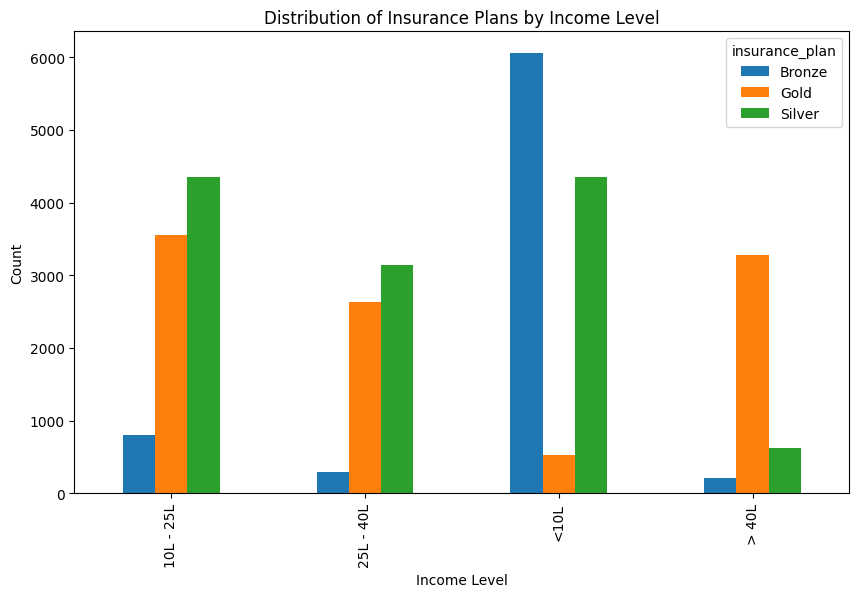

In [ ]:
crosstab.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.title('Distribution of Insurance Plans by Income Level')

<Axes: xlabel='insurance_plan', ylabel='income_level'>

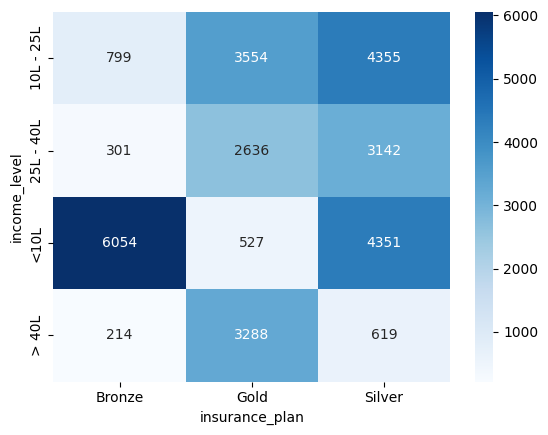

In [ ]:
sns.heatmap(crosstab, annot=True, cmap='Blues', fmt='g')

## **Feature Engineering**

Here, we are considering medical history also plays a major role whether person has to be given insurance or not. Let us just give risk_scores to each of the medical condition.

In [ ]:
df.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [ ]:
df['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())

,0,1
0,diabetes,None
1,diabetes,None
2,high blood pressure,None
3,no disease,None
4,diabetes,None
...,...,...
29899,high blood pressure,None
29900,diabetes,thyroid
29901,no disease,None
29902,thyroid,None


In [ ]:
df[['disease 1', 'disease 2']] = df['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df.sample(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease 1,disease 2
4299,37,Female,Southeast,Married,4,Obesity,Regular,Salaried,> 40L,70,Diabetes,Gold,28737,0,diabetes,None
28585,42,Male,Southeast,Married,2,Normal,Regular,Salaried,10L - 25L,10,High blood pressure & Heart disease,Silver,22107,0,high blood pressure,heart disease
12267,44,Male,Northwest,Unmarried,0,Normal,No Smoking,Freelancer,25L - 40L,37,Thyroid,Silver,15988,0,thyroid,None
2487,27,Female,Southeast,Married,3,Overweight,No Smoking,Salaried,<10L,9,Diabetes & Thyroid,Silver,19294,0,diabetes,thyroid
22287,28,Male,Southeast,Married,3,Underweight,Regular,Freelancer,> 40L,88,Diabetes & High blood pressure,Gold,27320,0,diabetes,high blood pressure
20495,30,Male,Southeast,Married,3,Overweight,Regular,Freelancer,25L - 40L,28,Diabetes,Silver,20479,0,diabetes,None
6650,29,Female,Southeast,Married,3,Underweight,Regular,Freelancer,25L - 40L,38,High blood pressure,Silver,19065,0,high blood pressure,None
15300,27,Male,Southeast,Married,3,Overweight,No Smoking,Self-Employed,> 40L,100,Diabetes,Gold,24495,0,diabetes,None
16230,38,Female,Southeast,Unmarried,1,Obesity,No Smoking,Self-Employed,10L - 25L,13,Thyroid,Silver,19784,0,thyroid,None
9761,26,Male,Northwest,Married,3,Overweight,Regular,Freelancer,<10L,2,Heart disease,Bronze,18097,0,heart disease,None


In [ ]:
risk_scores = {
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

In [ ]:
df['disease 1'].fillna('none', inplace=True)
df['disease 2'].fillna('none', inplace=True)

df['total_risk_score'] = df['disease 1'].map(risk_scores) + df['disease 2'].map(risk_scores)
df.sample(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease 1,disease 2,total_risk_score
18012,52,Male,Southwest,Married,2,Normal,Occasional,Salaried,25L - 40L,34,High blood pressure,Gold,27130,0,high blood pressure,none,6
25477,54,Male,Northeast,Unmarried,2,Normal,No Smoking,Self-Employed,> 40L,73,Heart disease,Gold,30268,0,heart disease,none,8
13533,52,Male,Southeast,Unmarried,2,Normal,Regular,Self-Employed,> 40L,54,Diabetes,Gold,30123,0,diabetes,none,6
9496,42,Female,Southwest,Married,2,Obesity,Occasional,Freelancer,10L - 25L,18,Diabetes,Silver,20398,0,diabetes,none,6
5286,33,Male,Northwest,Married,3,Overweight,Regular,Self-Employed,<10L,8,Thyroid,Bronze,14115,0,thyroid,none,5
9378,66,Female,Southeast,Married,2,Underweight,No Smoking,Freelancer,<10L,7,Diabetes,Silver,22517,0,diabetes,none,6
18400,50,Female,Southwest,Married,3,Overweight,No Smoking,Salaried,<10L,9,Heart disease,Silver,24957,0,heart disease,none,8
13486,55,Male,Southwest,Married,4,Normal,Regular,Freelancer,25L - 40L,35,Thyroid,Gold,29313,0,thyroid,none,5
9239,42,Male,Northeast,Married,3,Overweight,Regular,Salaried,25L - 40L,37,Thyroid,Bronze,14470,0,thyroid,none,5
9830,32,Male,Northwest,Unmarried,2,Overweight,Occasional,Salaried,10L - 25L,20,Diabetes & High blood pressure,Gold,26887,0,diabetes,high blood pressure,12


In [ ]:
#Normalize the total_risk_score column
df['normalized_risk_score'] = (df['total_risk_score'] - df['total_risk_score'].min()) / (df['total_risk_score'].max() - df['total_risk_score'].min())
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease 1,disease 2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,diabetes,none,6,0.428571


In [ ]:
df.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

This is ordinal data. We can use label encoding

In [ ]:
df['insurance_plan'] = df['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease 1,disease 2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,0,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,1,15610,0,diabetes,none,6,0.428571


In [ ]:
df.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

This is ordinal data (eg: 3<2<1 or Bachelors<Masters<PhD). So, data will be label encode for this column as well.

In [ ]:
# #Label encoding the income_level column
# df['income_level'] = le.fit_transform(df['income_level'])
# df.head()

# Or it can be mapped like this as well
df['income_level'] = df['income_level'].map({'<10L': 1, '10L - 25L' : 2, '25L - 40L' : 3, '> 40L' : 4})

In [ ]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease 1,disease 2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,0,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,0,diabetes,none,6,0.428571


In [ ]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df1 = pd.get_dummies(df, columns = nominal_cols, drop_first=True, dtype=int)
df1.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease 1,disease 2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,0,no disease,none,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,0,diabetes,none,...,0,0,0,1,0,0,1,0,0,1


In [ ]:
df1.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount',
       'genetical_risk', 'disease 1', 'disease 2', 'total_risk_score',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [ ]:
#Now that I have normalized_risk_score, drop the columns related to it like medical_history, disesae 1, disease 2
df1.drop(['medical_history', 'disease 1', 'disease 2','total_risk_score'], axis=1, inplace=True)
df1.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [ ]:
df1.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

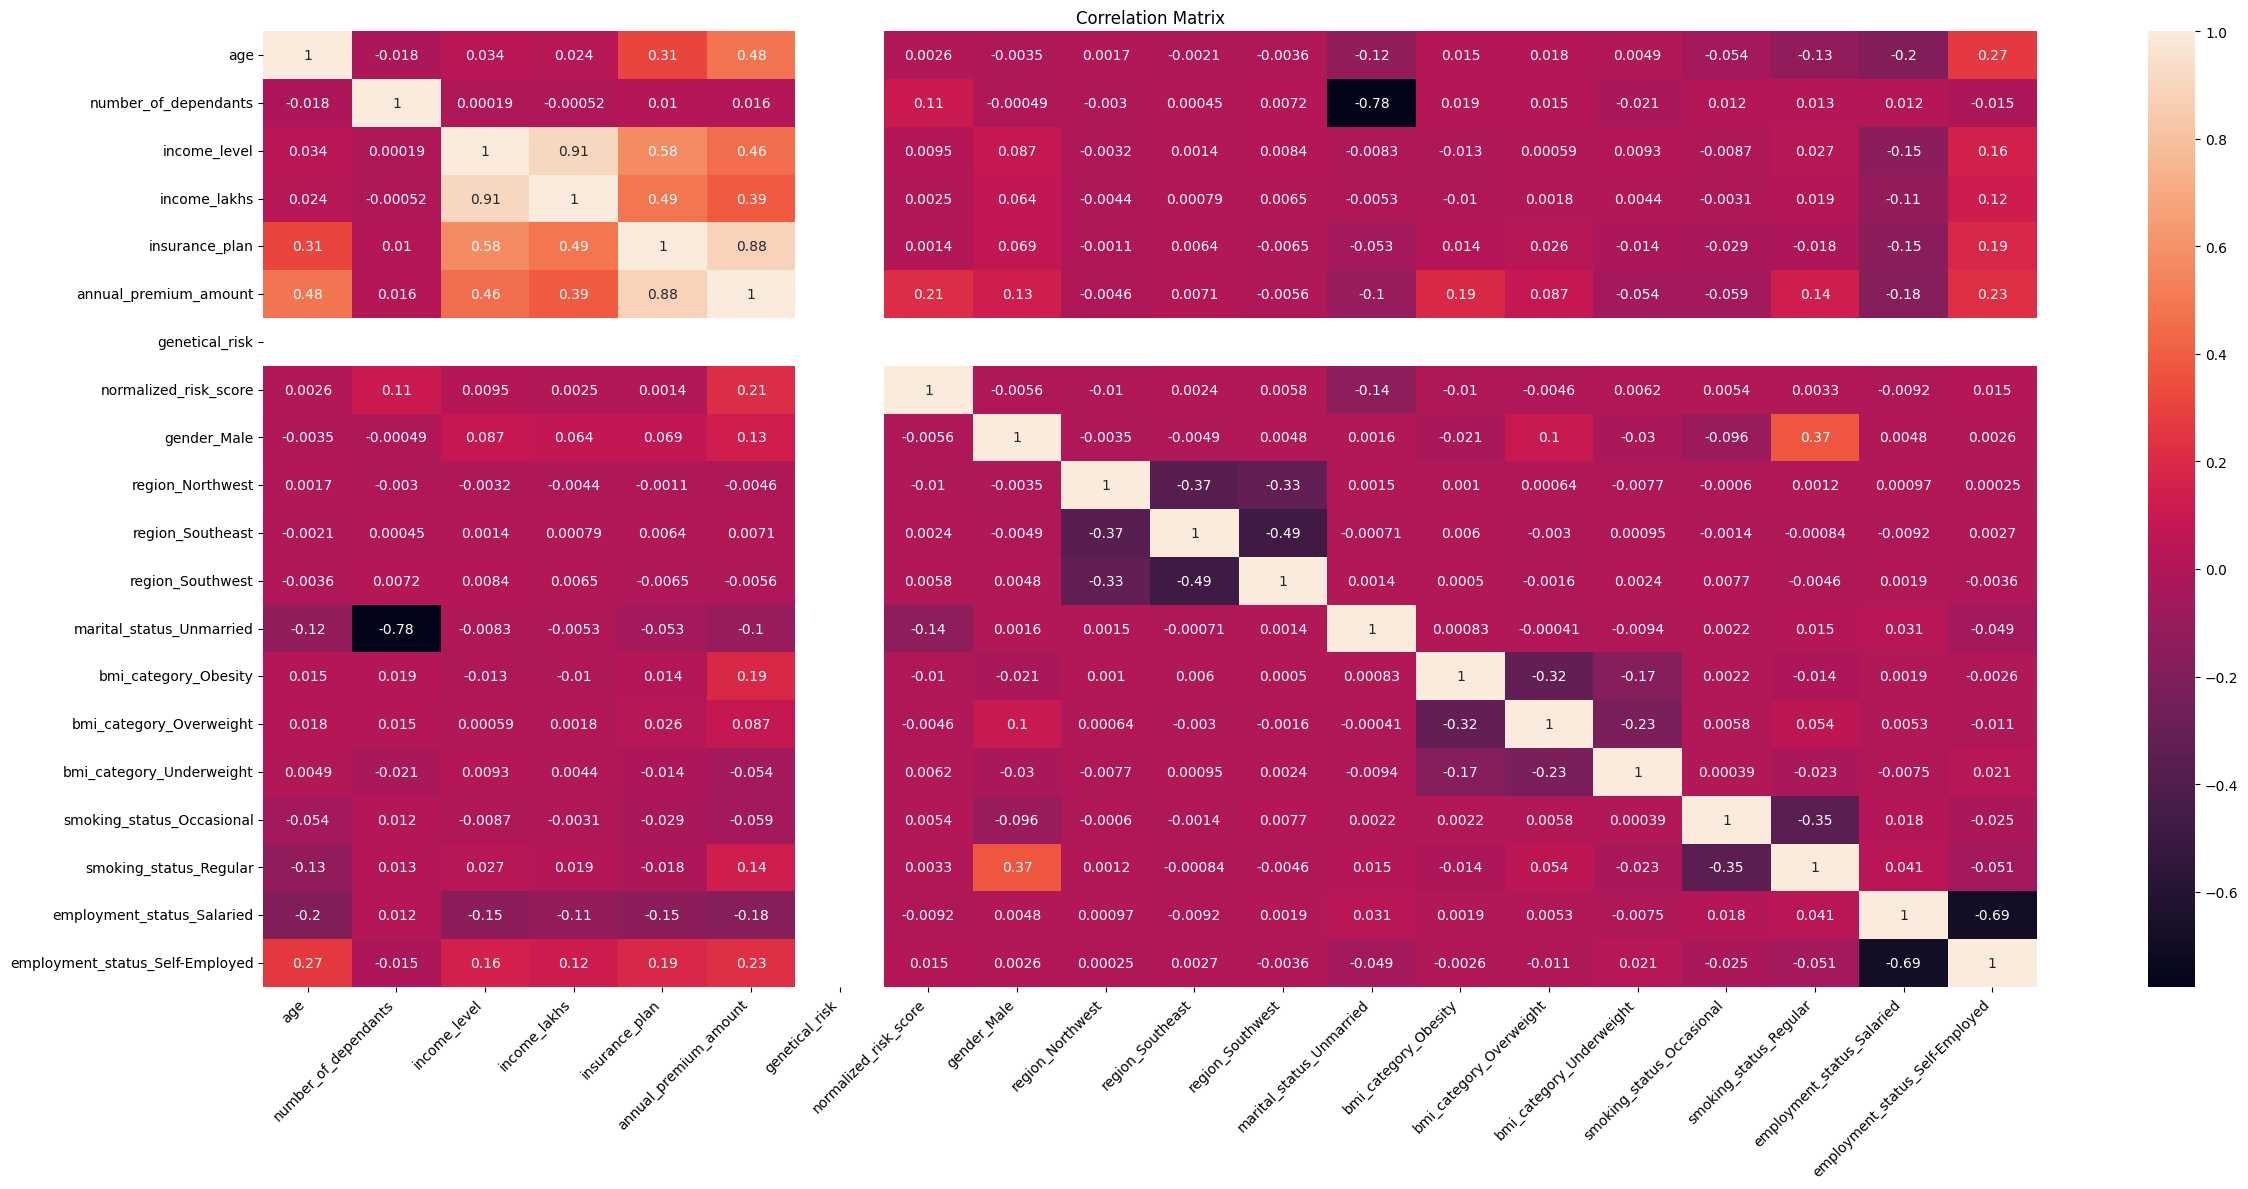

In [ ]:
#Check correlation between the columns
corr = df1.corr()

plt.figure(figsize=(25, 12))
sns.heatmap(corr, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Let us say 10 of my features are correlated and I want to get rid of multiple features, then we can use Cariance Inflation Factor. It will find out the relationship of one feature with rest of the features in an aggregate way.

In [ ]:
X = df1.drop('annual_premium_amount', axis=1)
y = df1['annual_premium_amount']

#Scaling the features
from sklearn.preprocessing import MinMaxScaler, StandardScaler
cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()

# Scale the selected columns and update the DataFrame
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale]) # Use cols_to_scale to select the columns to scale
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


A higher Variance Inflation Factor (VIF) indicates that a feature is highly correlated with other features in the dataset. VIF quantifies how much the variance of a feature’s estimated regression coefficient is increased due to multicollinearity (i.e., the correlation between features).

**Key Points:**

* VIF = 1: No correlation between the feature and other features.
* 1 < VIF < 5: Moderate correlation; usually acceptable.
* VIF > 5 (or 10): High correlation, indicating multicollinearity. A feature with a high VIF suggests that it can be predicted by other features, which can make the model unstable.


In feature reduction, features with high VIF values are often considered for removal because they add redundant information.









In [ ]:
# Now apply variance inflation factor
# from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Features'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [ ]:
calculate_vif(X)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,VIF,Features
0,3.921110,age
1,6.277193,number_of_dependants
2,13.887238,income_level
3,11.185689,income_lakhs
4,5.272027,insurance_plan
5,NaN,genetical_risk
6,3.811505,normalized_risk_score
7,2.598475,gender_Male
8,2.123295,region_Northwest
9,2.979759,region_Southeast


income_level and income_lakhs have high VIF which means they are highly correlated.

In [ ]:
#Let us drop the column income_level (since it has highest VIF) and calculate VIF again
calculate_vif(X.drop('income_level', axis=1))

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,VIF,Features
0,3.921110,age
1,6.277193,number_of_dependants
2,13.887238,income_level
3,11.185689,income_lakhs
4,5.272027,insurance_plan
5,NaN,genetical_risk
6,3.811505,normalized_risk_score
7,2.598475,gender_Male
8,2.123295,region_Northwest
9,2.979759,region_Southeast


Not income_lakhs VIF score also decreased. It is always better to drop column one by one and calculate VIF.

Now that VIF has reduced, drop income_level column

In [ ]:
X_reduced = X.drop('income_level', axis=1)
calculate_vif(X_reduced)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,VIF,Features
0,3.921110,age
1,6.277193,number_of_dependants
2,13.887238,income_level
3,11.185689,income_lakhs
4,5.272027,insurance_plan
5,NaN,genetical_risk
6,3.811505,normalized_risk_score
7,2.598475,gender_Male
8,2.123295,region_Northwest
9,2.979759,region_Southeast


## **Model Training**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
model_lr.score(X_train, y_train)

0.9530810722248505

In [ ]:
model_lr.score(X_test, y_test)

0.9545756331847348

In [ ]:
model_lr.coef_, model_lr.intercept_

(array([ 7.01426640e+03, -1.25905958e+03, -7.13739202e+02,  1.48064765e+04,
         2.27373675e-12,  5.98743079e+03,  5.03467563e+01, -3.34959474e+01,
         2.29348822e+01,  2.62759708e+01, -6.85528467e+02,  3.93121484e+03,
         1.98971289e+03,  6.17681290e+02,  8.30443367e+02,  2.79715758e+03,
        -7.23626494e+01,  2.35318304e+02]),
 5925.912142587418)

The first coefficient belongs to first column name age, second coef belongs to second column etc.

<Axes: xlabel='Coefficient', ylabel='Feature'>

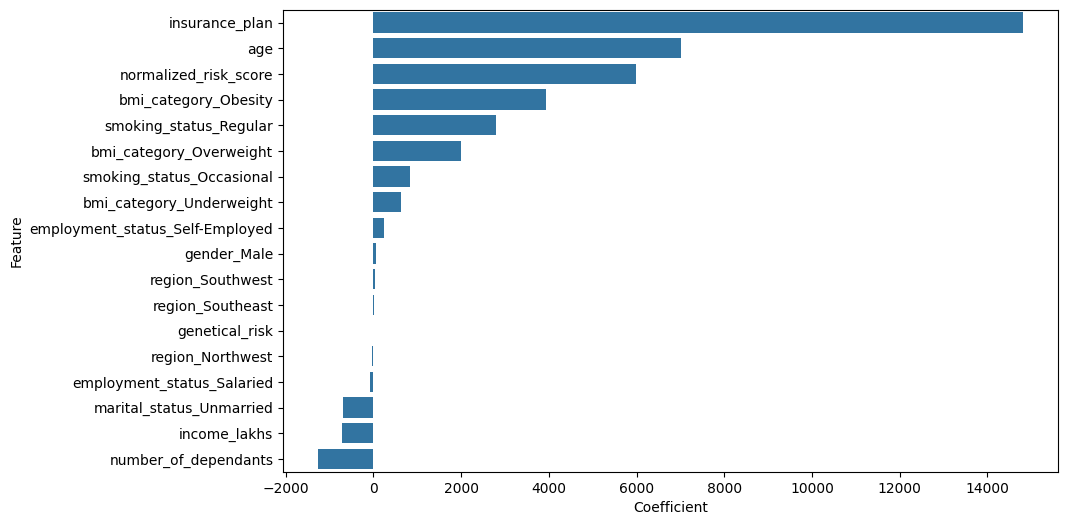

In [ ]:
# Printing these coefficients on a bar chart to check their contribution to final prediction
# Sort the value with highest feature importance and plot
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model_lr.coef_})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)

# coefficients = model_lr.coef_
# feature_names = X_reduced.columns

# plt.figure(figsize=(10, 6))
# plt.barh(feature_names, coefficients)
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.title('Feature Importance')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
regressors = {
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    # "Support Vector Machine": SVR(),
    "XGBoost": XGBRegressor()
}

In [ ]:
df_Results = pd.DataFrame(columns=['Model','MSE','R2'])
def evaluate_models(X_train, X_test, y_train, y_test, models, df_Results):
  for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(list(models.keys())[i])
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(np.sqrt(mse_train)))
    print("- R2 Score: {:.4f}".format(r2_train))
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(np.sqrt(mse_test)))
    print("- R2 Score: {:.4f}".format(r2_test))
    print('='*35)
    print('\n')
    df_Results = pd.concat([df_Results, pd.DataFrame({'Model': [list(models.keys())[i]], 'MSE': [np.sqrt(mse_test)], 'R2': [r2_test]})], ignore_index=True)
  return df_Results


In [ ]:
evaluate_models(X_train, X_test, y_train, y_test, regressors,df_Results)

Random Forest
Model performance for Training set
- Root Mean Squared Error: 127.6815
- R2 Score: 0.9997
Model performance for Test set
- Root Mean Squared Error: 339.1269
- R2 Score: 0.9976


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 17.0703
- R2 Score: 1.0000
Model performance for Test set
- Root Mean Squared Error: 438.1413
- R2 Score: 0.9960




<ipython-input-100-3fc9c126f0ce>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_Results = pd.concat([df_Results, pd.DataFrame({'Model': [list(models.keys())[i]], 'MSE': [np.sqrt(mse_test)], 'R2': [r2_test]})], ignore_index=True)


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1502.0378
- R2 Score: 0.9531
Model performance for Test set
- Root Mean Squared Error: 1472.6830
- R2 Score: 0.9546


Lasso
Model performance for Training set
- Root Mean Squared Error: 1502.1130
- R2 Score: 0.9531
Model performance for Test set
- Root Mean Squared Error: 1472.9886
- R2 Score: 0.9546


Ridge
Model performance for Training set
- Root Mean Squared Error: 1502.0404
- R2 Score: 0.9531
Model performance for Test set
- Root Mean Squared Error: 1472.7653
- R2 Score: 0.9546


ElasticNet
Model performance for Training set
- Root Mean Squared Error: 5309.8011
- R2 Score: 0.4137
Model performance for Test set
- Root Mean Squared Error: 5292.0325
- R2 Score: 0.4134


K-Nearest Neighbors
Model performance for Training set
- Root Mean Squared Error: 1751.6530
- R2 Score: 0.9362
Model performance for Test set
- Root Mean Squared Error: 2249.7751
- R2 Score: 0.8940


XGBoost
Model performance for Training 

,Model,MSE,R2
0,Random Forest,339.126855,0.997591
1,Decision Tree,438.141257,0.995979
2,Linear Regression,1472.682985,0.954576
3,Lasso,1472.988632,0.954557
4,Ridge,1472.765274,0.954571
5,ElasticNet,5292.032465,0.413436
6,K-Nearest Neighbors,2249.775068,0.893990
7,XGBoost,307.648504,0.998018


Seems like Random Forest Regressor, XGBoost Regressor and Decision Tree Regressor performed well.

## **Hyperparameter tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define models and their hyperparameter grids
models = {
    # 'RandomForest': {
    #     'model': RandomForestRegressor(),
    #     'params': {
    #         'n_estimators': [100, 200, 500],
    #         'max_depth': [None, 10, 20, 30],
    #         'min_samples_split': [2, 5, 10],
    #         'min_samples_leaf': [1, 2, 4]
    #     }
    # },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

# Function to perform RandomizedSearchCV for any given model and parameters
def tune_model_random(model, params, X_train, y_train):
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=10, cv=5,
                                       scoring='r2', random_state=42)
    random_search.fit(X_train, y_train)

    print(f"Best Parameters for {model.__class__.__name__}: {random_search.best_params_}")
    print(f"Best r2: {random_search.best_score_}")
    return random_search.best_estimator_, random_search.best_score_

# Loop through models and tune hyperparameters using RandomizedSearchCV
best_models = {}
best_r2_score = -np.inf  # Initialize with a very low R² score
best_model_name = None
best_model = None

for model_name, model_info in models.items():
    print(f"Tuning {model_name}...")
    tuned_model, r2_score = tune_model_random(model_info['model'], model_info['params'], X_train, y_train)

    best_models[model_name] = tuned_model

    # Check if the current model has the best R² score
    if r2_score > best_r2_score:
        best_r2_score = r2_score
        best_model_name = model_name
        best_model = tuned_model

# Output the best model based on R² score
print(f"\nBest Model: {best_model_name}")
print(f"Best R² Score: {best_r2_score}")
print(f"Best Model Parameters: {best_model.get_params()}")


Tuning XGBoost...
Best Parameters for XGBRegressor: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best r2: 0.9980272207761235
Tuning DecisionTree...
Best Parameters for DecisionTreeRegressor: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
Best r2: 0.9972880582171764

Best Model: XGBoost
Best R² Score: 0.9980272207761235
Best Model Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'mo

All the three models performed well. XGBoost performed a bit better.



* Best Model: XGBoost
* Best R² Score: 0.9817240068818764
* Best Model Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}

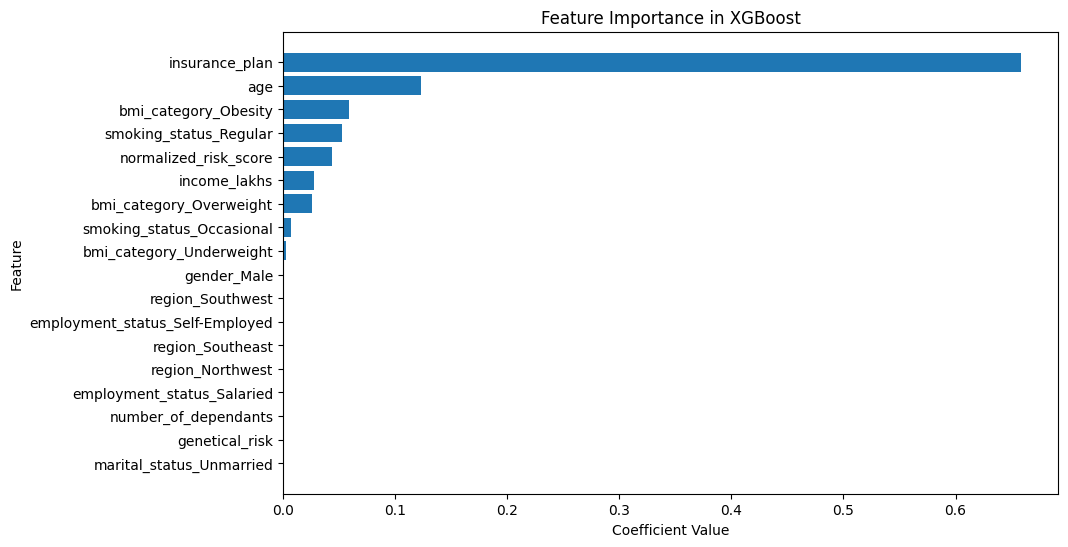

In [ ]:
feature_importances = best_model.feature_importances_
coed_df1 = pd.DataFrame(feature_importances, index = X_test.columns, columns = ['Coeffiecients'])
coed_df1 = coed_df1.sort_values(by='Coeffiecients', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(coed_df1.index, coed_df1['Coeffiecients'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost')
plt.show()

The model seems to give really good r2 score. But we cannot rely solely on r2 score. Further error analysis is required.

### **Error Analysis**

In [ ]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residuals': residuals, 'Residuals %': residuals_pct})
results_df.head()

,Actual,Predicted,Residuals,Residuals %
10766,31246,31537.693359,291.693359,0.933538
14504,19646,19663.373047,17.373047,0.088430
27896,15040,15656.195312,616.195312,4.097043
11396,16152,16048.509766,-103.490234,-0.640727
28144,33476,33437.292969,-38.707031,-0.115626


<Axes: xlabel='Residuals %', ylabel='Count'>

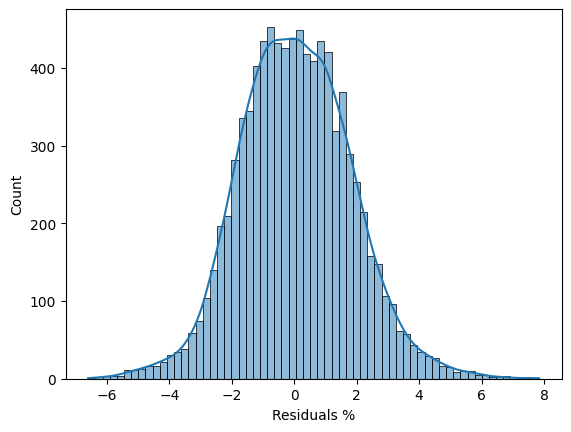

In [ ]:
sns.histplot(results_df['Residuals %'], kde=True)

In [ ]:
results_df.shape

(8952, 4)

In [ ]:
# Get the recorda that have more than 10% margin of error
error_threshold = 10
high_error_records = results_df[np.abs(results_df['Residuals %']) > error_threshold]
high_error_records.shape

(0, 4)

In [ ]:
# Percentage of these extreme errors
high_error_pct = (high_error_records.shape[0] / results_df.shape[0]) * 100
high_error_pct

0.0

In [ ]:
# Check how many records have > 50% error margin
results_df[np.abs(results_df['Residuals %']) > 50].sort_values(by='Residuals %', ascending=False)

,Actual,Predicted,Residuals,Residuals %


This model cannot be deployed. Further analysis is required.

In [ ]:
# high_error_records are the records in X_test. Get these high_error_records from X_test
high_error_records_df = X_test.loc[high_error_records.index]
high_error_records_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed


In [ ]:
high_error_records_df.shape

(0, 18)

Let us check if error rate is high in specific income group.

In [ ]:
### Export the model
import joblib
joblib.dump(best_model, 'model_rest.joblib')

['model_rest.joblib']

In [ ]:
### We have to export scaler object as we have scaled everything
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale ': cols_to_scale
}
joblib.dump(scaler_with_cols, 'scaler_rest.joblib')

['scaler_rest.joblib']